# Temporal interpolation of landsat images

The Landsat Analysis Ready Data (GLAD ARD) developed by the Global Land Analysis and Discovery (GLAD) provides spatially and temporally consistent inputs for land cover mapping and change detection. The GLAD ARD represent a 16-day time-series of tiled Landsat normalized surface reflectance from 1997 to present (source 
https://glad.umd.edu/book/overview). 

The GLAD ARD data can be download from the https://glad.umd.edu/dataset/landsat_v1.1/ previous autentifcation.
For this exercise we are going to use a portion of TILE 015E_38N, which is located in the south of Italy (Sicily), for the year **2018, 2019, 2020**. 

The temporal series for each tile is labeled following this numerical nomenclature. 

In [22]:
! head -43  geodata/glad_ard/16d_intervals.csv  | tail -6

2017 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874         
2018 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897         
2019 898 899 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920         
2020 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943         
2021 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963 964 965 966         
2022 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989         


Where the first column identify the year, and the others the 16-day time-series.

For example the below figure depict three images for the **876, 899, 922** time-frame (second 16-day time-serie).

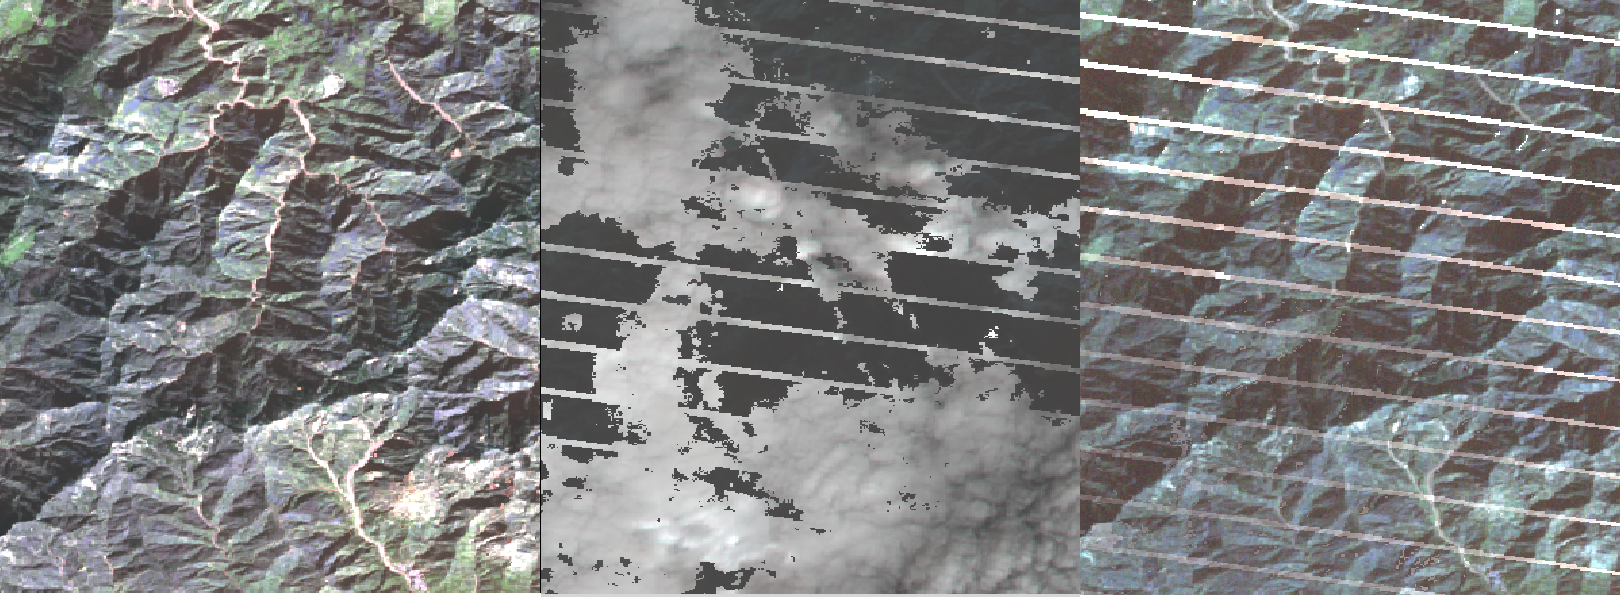

In [1]:
from IPython.display import Image
Image("../images/glad_ard_876_899_922_crop.png")

## Data download 

Per convenience the images have been downloaded and cropped already with the following lines.

    for INTER in $(grep -e ^2018 -e ^2019 -e ^2020 geodata/glad_ard//16d_intervals.csv | awk '{ $1=""; print $0}') ; do                                                                                               
    curl --connect-timeout 600 -u user:password -X GET https://glad.umd.edu/dataset/landsat_v1.1/38N/015E_38N/$INTER.tif -o geodata/glad_ard/$INTER.tif
    gdal_translate -co COMPRESS=DEFLATE -co ZLEVEL=9  -projwin 15.24 38.11 15.34 38 geodata/glad_ard/$INTER.tif geodata/glad_ard/${INTER}_crop.tif      
    done

## Image characteristics

The images have the following characteristic:

In [3]:
! gdalinfo -mm   geodata/glad_ard/922_crop.tif

Driver: GTiff/GeoTIFF
Files: geodata/glad_ard/922_crop.tif
Size is 400, 440
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (15.240000000000000,38.109999999999999)
Pixel Size = (0.000250000000000,-0.000250000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (  15.2400000,  38.1100000) ( 15d14'24.00"E, 38d 6'36.00"N)
Lower Left  (  15.2400000,  38.0000000) ( 15d14'24.00"E, 38d 0' 0.00"N

**Bands features**

- 1 Normalized surface reflectance of blue band
- 2 Normalized surface reflectance of green band
- 3 Normalized surface reflectance of red band
- 4 Normalized surface reflectance of NIR band
- 5 Normalized surface reflectance of SWIR1 band
- 6 Normalized surface reflectance of SWIR2 band                                              
- 7 Normalized brightness temperature
- 8 Observation quality code (QA)


**The band 8 include a Quality Assessment (QA) code**

|QA code |Description |Quality | 
|:-----|:---------|:------|
|0      |Nodata                                                         |stripes and out of the image|
|1      |Land                                                           |clear-sky|
|2      |Water                                                          |clear-sky|
|3      |Cloud                                                          |cloud contaminated|
|4      |Cloud shadow                                                   |shadow contaminated|
|5      |Hillshade                                                      |clear-sky|
|6      |Snow                                                           |clear-sky|
|7      |Haze                                                           |cloud contaminated|
|8      |Cloud buffer                                                   |cloud contaminated|
|9      |Shadow buffer                                                  |shadow contaminated|
|10     |Shadow high likelihood                                         |shadow contaminated|
|11     |Additional cloud buffer over land                              |clear-sky|
|12     |Additional cloud buffer over water                             |lear-sky|
|14     |Additional shadow buffer over land                             |lear-sky|
|15     |Land, water detected but not used                              |lear-sky|
|16     |Additional cloud buffer over land, water detected but not used |lear-sky|
|17     |Additional shadow buffer over land, water detected but not used|lear-sky|

The band 8 can be used to mask out areas that do not belong to land (QA=1) and water (QA=2) class.

In the below figures we use the same images than before and we apply a masking procedure using the band 8. The black part has pixel value equal to 0 and is labled as NoData

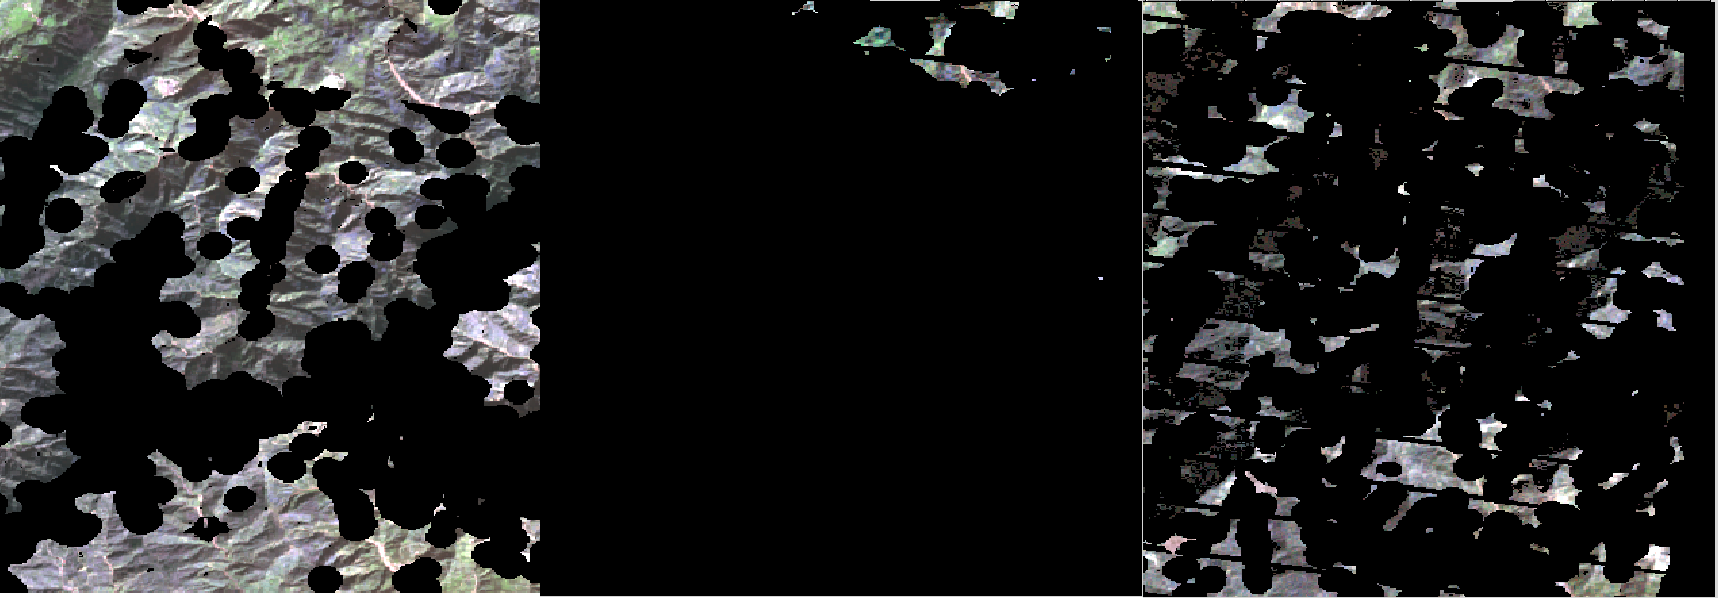

In [4]:
from IPython.display import Image
Image("../images/glad_ard_876_899_922_crop_msk.png")

We decided to compute a temporal median in order to reduce the area with no data. In other words we have combined the images that belong to the same period (876, 899, 922) and select the median value. During the opearion we use the band 8 to select only good-quality pixels.

## Temporal composite
For each of the 16-day time-series we composite the 3 images (from the year 2018,2019,2020) taking median among them. The composite has been done by retaining from band 8 (-bndnodata 7) only pixels that belong to land (QA=1) or water (QA=2)

In [3]:
%%bash

echo 01 02 03 04 05 06 07 08 09 $( seq 10 23 )   | xargs -n 1 -P 2  bash -c $'
day=$1

## median composite 
pkcomposite $( grep -e ^2019 -e ^2020 -e ^2018 geodata/glad_ard/16d_intervals.csv | awk -v day=$day \
\'{ print $(day+1)  }\' |  xargs  -I {}  -n 1 ls geodata/glad_ard/{}_crop.tif | xargs  -I {}  -n 1 echo -i  {}  ) \
-ot UInt16 -co COMPRESS=LZW -co ZLEVEL=9  -cr median -dstnodata 0  -bndnodata 7 \
-srcnodata 0  -srcnodata 3  -srcnodata 4 -srcnodata 5 -srcnodata 6 -srcnodata 7 -srcnodata 8 -srcnodata 9 \
-srcnodata 10 -srcnodata 11 -srcnodata 12 -srcnodata 13 -srcnodata 14 -srcnodata 15  -srcnodata 16 -srcnodata 17 \
-o geodata/glad_ard/median_$day.tif

##### The obtaine mosaic still contains 8 bands. Therefore we run gdal_translate to select only 6 bands
              
gdal_translate  -co COMPRESS=LZW -co ZLEVEL=9 -b 1 -b 2 -b 3 -b 4 -b 5 -b 6 -a_nodata 0 \
geodata/glad_ard/median_$day.tif  geodata/glad_ard/median_${day}_6bs.tif
rm geodata/glad_ard/median_$day.tif
' _

00...10.....20...10.30......40.20...50.....3060......7040......80.50....90....100 - done.
Input file size is 400, 440
0...10...20...30...40...5060...60...70...80...90...100 - done.
0......10..70..20.....3080.....40..90...50....100 - done.
Input file size is 400, 440
0...10...20...30...40...50...60...70...80...90...100 - done.
.0..60.10.....20....7030.....40..80...50.....9060......70100 - done.
.Input file size is 400, 440
0...10...20...30...40...50....60...70...80...90...100 - done.
0...80..10.....2090....30.....40100 - done.
Input file size is 400, 440
0....10...20...30...40...50.....60...70...80...90...100 - done.
500.....10....6020....30....40...70.50......8060.....90....70.100 - done.
.Input file size is 400, 440
0....10...20...30...40...5080...60...70...80...90...100 - done.
.0.....10.90...20.....30...40100 - done.
.Input file size is 400, 440
0....10...20...30...40...50.50....60...70...80...90...100 - done.
..060....10....20....3070....40.....8050......6090......70...80100 - done

After the temporal composite some images present areas with NoData. 

Below the results of the median aggregation of the previus 3 images. 

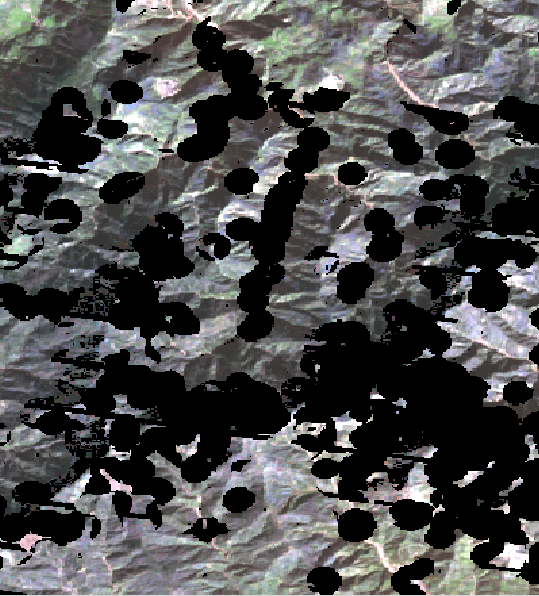

In [4]:
from IPython.display import Image
Image("../images/glad_ard_median_02_6bs.png")

## Temporal interpolation

We re-fill (gap-filling) all the area labeled as NoData=0 (black area in the above immages) using temporal interpolation by means of [Akima](https://en.wikipedia.org/wiki/Akima_spline) and [Steffen](https://www.weatherclasses.com/uploads/1/3/1/3/131359169/steffen_interpolation_paper.pdf) algorithm.

[Approximation](http://spatial-ecology.net/docs/source/lectures/lect_20210427_Approximation.pdf)

In [5]:
%%bash 

# for semplicity we concentrate in only on band 1  
echo 1  | xargs -n 1 -P 1  bash -c $'
B=$1 # band 

## extract one band for all the 16-day time-series
for day in 01 02 03 04 05 06 07 08 09 $( seq 10 23 ) ; do
gdalbuildvrt -srcnodata 0 -vrtnodata 0 -overwrite -b $B geodata/glad_ard/median_${day}_${B}b.vrt \
geodata/glad_ard/median_${day}_6bs.tif
done

## replicate 3 times the 16-day time-series to avoid temporal border effect
gdalbuildvrt -srcnodata 0 -vrtnodata 0 -separate  -overwrite geodata/glad_ard/median_tseries_${B}b.vrt \
geodata/glad_ard/median_??_${B}b.vrt geodata/glad_ard/median_??_${B}b.vrt geodata/glad_ard/median_??_${B}b.vrt 

## gap filling with the akima spline
pkfilter -of GTiff -co COMPRESS=LZW -co ZLEVEL=9 -nodata 0 -f smoothnodata -dz 1 -interp akima \
-i geodata/glad_ard/median_tseries_${B}b.vrt -o geodata/glad_ard/median_akima_${B}b_tmp.tif

## reselecto only the 16-day time-series in the center
gdal_translate  -co COMPRESS=LZW -co ZLEVEL=9 $(for b in $(seq 24 46); do echo "-b $b" ; done) \
geodata/glad_ard/median_akima_${B}b_tmp.tif geodata/glad_ard/median_akima_${B}b.tif
rm geodata/glad_ard/median_akima_${B}b_tmp.tif

## gap filling with the steffen spline
pkfilter -of GTiff -co COMPRESS=LZW -co ZLEVEL=9 -nodata 0 -f smoothnodata -dz 1 -interp steffen \
-i geodata/glad_ard/median_tseries_${B}b.vrt -o geodata/glad_ard/median_steffen_${B}b_tmp.tif

## reselecto only the 16-day time-series in the center
gdal_translate  -co COMPRESS=LZW -co ZLEVEL=9 $(for b in $(seq 24 46); do echo "-b $b" ; done) \
geodata/glad_ard/median_steffen_${B}b_tmp.tif geodata/glad_ard/median_steffen_${B}b.tif
rm geodata/glad_ard/median_steffen_${B}b_tmp.tif
' _

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...

At this point all the immages have been re-fill. 

## Plotting the temporal interpolation for band 1

In [39]:
%%bash 
R --vanilla -q
# open a terminal and run this line for the installation
# install.packages("Rcpp")     
# install.packages("rgdal")
# install.packages("raster")
library(sp)
library(raster)
stack = stack("geodata/glad_ard/median_steffen_1b.tif")
png("../images/median_steffen_1b.png")
pal = colorRampPalette(rev(rainbow(20)))
plot(stack , col=pal(20))
dev.off()
stack = stack("geodata/glad_ard/median_tseries_1b.vrt")
png("../images/median_tseries_1b.png")
pal = colorRampPalette(rev(rainbow(20)))
plot(stack , col=pal(20))
dev.off()

> # open a terminal and run this line for the installation
> # install.packages("Rcpp")     
> # install.packages("rgdal")
> # install.packages("raster")
> library(sp)
> library(raster)
> stack = stack("geodata/glad_ard/median_steffen_1b.tif")
> png("../images/median_steffen_1b.png")
> pal = colorRampPalette(rev(rainbow(20)))
> plot(stack , col=pal(20))
> dev.off()
null device 
          1 
> stack = stack("geodata/glad_ard/median_tseries_1b.vrt")
> png("../images/median_tseries_1b.png")
> pal = colorRampPalette(rev(rainbow(20)))
> plot(stack , col=pal(20))
> dev.off()
null device 
          1 
> 


**Before interpolation**

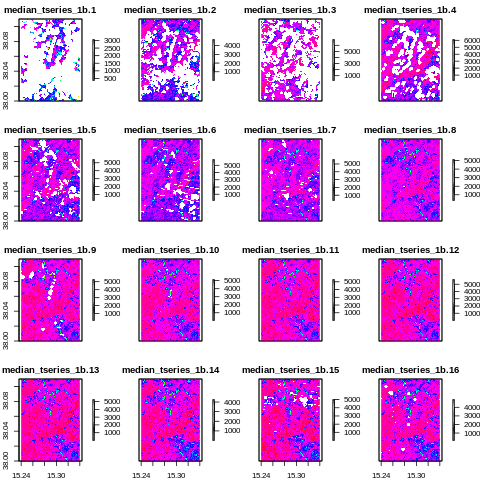

In [37]:
from IPython.display import Image
Image("../images/median_tseries_1b.png")

**After interpolation**

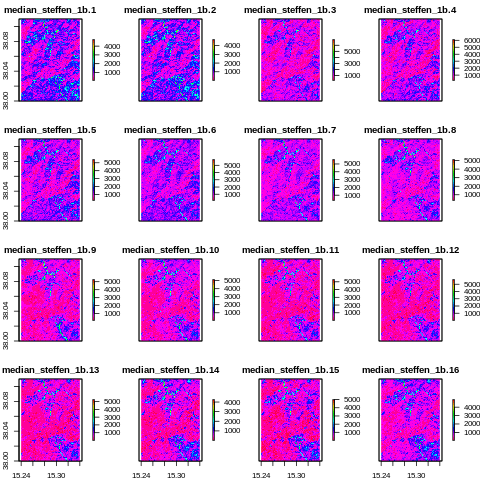

In [38]:
from IPython.display import Image
Image("../images/median_steffen_1b.png")

## Assessing the temporal interpolation

We select one pixel in the images and we plot its values acros time. 

In [42]:
%%bash
echo "day tseries akima steffen" > geodata/glad_ard/day_orig_akima_steffen.txt 
paste -d " " <(for day in  01 02 03 04 05 06 07 08 09 $(seq 10 23); do  expr $day \* 16 - 8 ; done) \
 <(gdallocationinfo -valonly -geoloc geodata/glad_ard/median_tseries_1b.vrt       15.2866 38.0539 | head -23 ) \
 <(gdallocationinfo -valonly -geoloc geodata/glad_ard/median_akima_1b.tif         15.2866 38.0539)\
 <(gdallocationinfo -valonly -geoloc geodata/glad_ard/median_steffen_1b.tif 15.2866 38.0539) \
 >> geodata/glad_ard/day_orig_akima_steffen.txt 

We obtained a table with 4 Columns. The zero in the second column rapresent No-Data and is the one that we had interpolated. 

In [43]:
! cat geodata/glad_ard/day_orig_akima_steffen.txt 

day tseries akima steffen
8 0 1028 1056
24 0 1176 1182
40 1309 1309 1309
56 0 1427 1416
72 0 1538 1522
88 1629 1629 1629
104 1554 1554 1554
120 1577 1577 1577
136 1370 1370 1370
152 1465 1465 1465
168 1466 1466 1466
184 1412 1412 1412
200 1342 1342 1342
216 1239 1239 1239
232 1376 1376 1376
248 1479 1479 1479
264 0 1421 1351
280 0 1277 1224
296 0 1107 1096
312 968 968 968
328 0 843 885
344 802 802 802
360 0 894 929


We import in R for plotting

In [44]:
%%bash 
R --vanilla -q
tseries = read.table("geodata/glad_ard/day_orig_akima_steffen.txt", sep=" " , header=TRUE)
str(tseries)
png("../images/plot_interpolation1.png")
plot(tseries$day, tseries$tseries, pch=4, cex=2, col="blue", xlab=("Day of the year"), ylab=("Spectral digital number") )
points(tseries$day, tseries$steffen, col="red", pch=19 )
points(tseries$day, tseries$akima, pch=1 )
legend(x=1,y=700,c("Original","Steffen interp","Akima interp"),cex=1.4,col=c("blue","red","black"),pch=c(4,19,1))
dev.off()

> tseries = read.table("geodata/glad_ard/day_orig_akima_steffen.txt", sep=" " , header=TRUE)
> str(tseries)
'data.frame':	23 obs. of  4 variables:
 $ day    : int  8 24 40 56 72 88 104 120 136 152 ...
 $ tseries: int  0 0 1309 0 0 1629 1554 1577 1370 1465 ...
 $ akima  : int  1028 1176 1309 1427 1538 1629 1554 1577 1370 1465 ...
 $ steffen: int  1056 1182 1309 1416 1522 1629 1554 1577 1370 1465 ...
> png("../images/plot_interpolation1.png")
> plot(tseries$day, tseries$tseries, pch=4, cex=2, col="blue", xlab=("Day of the year"), ylab=("Spectral digital number") )
> points(tseries$day, tseries$steffen, col="red", pch=19 )
> points(tseries$day, tseries$akima, pch=1 )
> legend(x=1,y=700,c("Original","Steffen interp","Akima interp"),cex=1.4,col=c("blue","red","black"),pch=c(4,19,1))
> dev.off()
null device 
          1 
> 


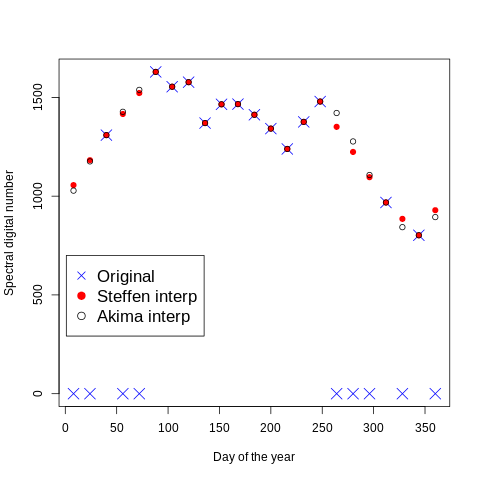

In [45]:
from IPython.display import Image
Image("../images/plot_interpolation1.png")

You can noticed that Steffen and Akima present same differences only in the interpolated pixels. The orginal values have been kept constant for both method.

## Savitzky–Golay smoothing filter

We can use the Savitzky–Golay filter to smooth out the spectral response. 

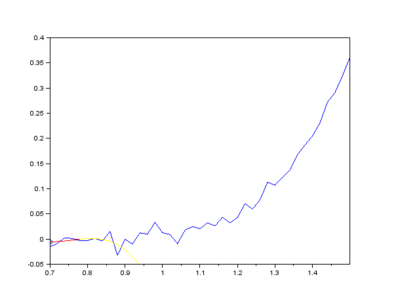

In [46]:
from IPython.display import Image
Image("../images/Savitzky_Golay.gif")

Run Savitzky–Golay smoothing filter

In [48]:
%%bash

echo 1 | xargs -n 1 -P 1  bash -c $'
B=$1
pkfilter -co COMPRESS=LZW -co ZLEVEL=9 -f savgolay -nl 3 -nr 3 -m 2 -pad replicate -i geodata/glad_ard/median_akima_${B}b.tif -o geodata/glad_ard/median_savgolay_${B}b.tif
' _

opening output image geodata/glad_ard/median_savgolay_1b.tif with 23 bands
0...10...20...30...40...50...60...70...80...90...100 - done.


## Assessing the Savitzky–Golay smoothing filter

We use the lat lon location to extract the value for the Savitzky–Golay smoothing filter and we plot against the previus values

In [49]:
%%bash
echo "savgolay" > geodata/glad_ard/savgolay.txt
gdallocationinfo -valonly -geoloc geodata/glad_ard/median_savgolay_1b.tif 15.2866 38.0539  >> geodata/glad_ard/savgolay.txt
paste -d " " geodata/glad_ard/day_orig_akima_steffen.txt geodata/glad_ard/savgolay.txt > geodata/glad_ard/day_orig_akima_steffen_savgolay.txt

In [50]:
! cat geodata/glad_ard/day_orig_akima_steffen_savgolay.txt

day tseries akima steffen savgolay
8 0 1028 1056 1072
24 0 1176 1182 1166
40 1309 1309 1309 1294
56 0 1427 1416 1444
72 0 1538 1522 1533
88 1629 1629 1629 1600
104 1554 1554 1554 1574
120 1577 1577 1577 1517
136 1370 1370 1370 1468
152 1465 1465 1465 1450
168 1466 1466 1466 1430
184 1412 1412 1412 1398
200 1342 1342 1342 1330
216 1239 1239 1239 1328
232 1376 1376 1376 1374
248 1479 1479 1479 1418
264 0 1421 1351 1406
280 0 1277 1224 1286
296 0 1107 1096 1117
312 968 968 968 956
328 0 843 885 866
344 802 802 802 839
360 0 894 929 853


We import in R for plotting

In [51]:
%%bash 
R --vanilla -q
tseries = read.table("geodata/glad_ard/day_orig_akima_steffen_savgolay.txt", sep=" " , header=TRUE)
str(tseries)
png("../images/plot_interpolation2.png")
plot(tseries$day ,  tseries$tseries , pch=4 , cex = 2 , col="blue" , xlab=("Day of the year") , ylab=("Spectral digital number") )
points(tseries$day , tseries$steffen  , col="red" , pch=19 )
points(tseries$day , tseries$akima , pch=1 )
points(tseries$day , tseries$savgolay , pch=3 , col="green")
legend(x=1,y=700,c("Original","Steffen interp","Akima interp","Savitzky-Golay smoothness"),cex=1.4,col=c("blue","red","black",col="green"),pch=c(4,19,1,3))
dev.off()

> tseries = read.table("geodata/glad_ard/day_orig_akima_steffen_savgolay.txt", sep=" " , header=TRUE)
> str(tseries)
'data.frame':	23 obs. of  5 variables:
 $ day     : int  8 24 40 56 72 88 104 120 136 152 ...
 $ tseries : int  0 0 1309 0 0 1629 1554 1577 1370 1465 ...
 $ akima   : int  1028 1176 1309 1427 1538 1629 1554 1577 1370 1465 ...
 $ steffen : int  1056 1182 1309 1416 1522 1629 1554 1577 1370 1465 ...
 $ savgolay: int  1072 1166 1294 1444 1533 1600 1574 1517 1468 1450 ...
> png("../images/plot_interpolation2.png")
> plot(tseries$day ,  tseries$tseries , pch=4 , cex = 2 , col="blue" , xlab=("Day of the year") , ylab=("Spectral digital number") )
> points(tseries$day , tseries$steffen  , col="red" , pch=19 )
> points(tseries$day , tseries$akima , pch=1 )
> points(tseries$day , tseries$savgolay , pch=3 , col="green")
> legend(x=1,y=700,c("Original","Steffen interp","Akima interp","Savitzky-Golay smoothness"),cex=1.4,col=c("blue","red","black",col="green"),pch=c(4,19,1,3))
> dev.

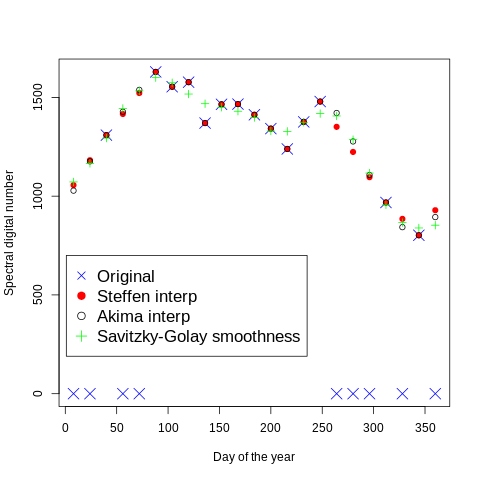

In [52]:
from IPython.display import Image
Image("../images/plot_interpolation2.png")

## Wavelet prediction

We use the Wavelet tecnique to predic the value for the 15 of each month

In [53]:
%%bash 

echo 1 | xargs -n 1 -P 1  bash -c $'
B=$1
pkfilter -of GTiff -co COMPRESS=LZW -co ZLEVEL=9 \
$(for day in  01 02 03 04 05 06 07 08 09 $( seq 10 23 )  ; do  echo "-win"  $(expr $day \\* 16  - 8) ; done) \
$(for day in  01 02 03 04 05 06 07 08 09 10 11 12   ; do  echo "-wout"  $(expr $day \\* 31  - 15) "-fwhm" 50  ; done  )  \
-i geodata/glad_ard/median_akima_${B}b.tif  -o geodata/glad_ard/median_akima_wavelet_${B}b.tif
' _

opening output image geodata/glad_ard/median_akima_wavelet_1b.tif with 12 bands
0...10...20...30...40...50...60...70...80...90...100 - done.


In [54]:
%%bash 
echo "day wavelet" > geodata/glad_ard/day_wavelet.txt
paste -d " " <(  for day in  01 02 03 04 05 06 07 08 09 10 11 12   ; do    expr $day \* 31  - 15  ; done   ) \
<(gdallocationinfo -valonly  -geoloc geodata/glad_ard/median_akima_wavelet_1b.tif 15.2866 38.0539 )  >> geodata/glad_ard/day_wavelet.txt
cat geodata/glad_ard/day_wavelet.txt

day wavelet
16 1204
47 1363
78 1526
109 1542
140 1467
171 1424
202 1353
233 1369
264 1350
295 1129
326 915
357 842


We import in R for plotting

In [55]:
%%bash 
R --vanilla -q
tseries1 = read.table("geodata/glad_ard/day_orig_akima_steffen_savgolay.txt", sep=" " , header=TRUE)
tseries2 = read.table("geodata/glad_ard/day_wavelet.txt", sep=" " , header=TRUE)
png("../images/plot_interpolation3.png" )
plot(tseries1$day ,  tseries1$tseries , pch=4 , cex = 2 , col="blue" , xlab=("Day of the year") , ylab=("Spectral digital number") )
points(tseries1$day , tseries1$steffen  , col="red" , pch=19 )
points(tseries1$day , tseries1$akima , pch=1 )
points(tseries1$day , tseries1$savgolay , pch=3 , col="green")
points(tseries2$day , tseries2$wavelet , pch=5 , col="orange")
legend(x=1,y=700,c("Original","Steffen interp","Akima interp","Savitzky-Golay smoothness","Wavelet prediction"),cex=1.4,col=c("blue","red","black","green","orange"),pch=c(4,19,1,3,5))
dev.off()

> tseries1 = read.table("geodata/glad_ard/day_orig_akima_steffen_savgolay.txt", sep=" " , header=TRUE)
> tseries2 = read.table("geodata/glad_ard/day_wavelet.txt", sep=" " , header=TRUE)
> png("../images/plot_interpolation3.png" )
> plot(tseries1$day ,  tseries1$tseries , pch=4 , cex = 2 , col="blue" , xlab=("Day of the year") , ylab=("Spectral digital number") )
> points(tseries1$day , tseries1$steffen  , col="red" , pch=19 )
> points(tseries1$day , tseries1$akima , pch=1 )
> points(tseries1$day , tseries1$savgolay , pch=3 , col="green")
> points(tseries2$day , tseries2$wavelet , pch=5 , col="orange")
> legend(x=1,y=700,c("Original","Steffen interp","Akima interp","Savitzky-Golay smoothness","Wavelet prediction"),cex=1.4,col=c("blue","red","black","green","orange"),pch=c(4,19,1,3,5))
> dev.off()
null device 
          1 
> 


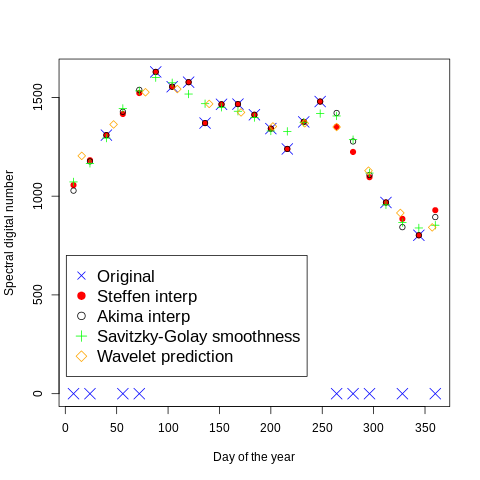

In [56]:
from IPython.display import Image
Image("../images/plot_interpolation3.png")